## SETUP

In [2]:
## docker: docker_slim
source('./../../../../my_utils/funcs_R/my_rutils.R')
source("./../../helper_funs.r")
suppressMessages(suppressWarnings(library(DESeq2)))
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(sctransform)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(gplots)))
suppressMessages(suppressWarnings(library(veloviz)))

save.dir <- save.dir <- './figs/figs_feb_26_2/'

fs <- 4
fs.small <- 3

## GET DATA

In [3]:
data.dir <- './../../../data/pbmc/'
load(paste0(data.dir,'referenceAnnot.rda'))
load(paste0(data.dir,'referenceCounts.rda'))

counts <- referenceCounts
celltype <- referenceAnnot

rm(referenceAnnot, referenceCounts)

## combine tcells subtypes
t.cell.subtypes <- c('cytotoxict', 'memoryt', 'naivecytotoxic', 'naivet', 'regulatoryt', 'thelper')
celltype[celltype %in% t.cell.subtypes] <- 'tcells'
table(celltype)

celltype
   bcells monocytes        nk    tcells 
      330       129       769       912 

In [4]:
## coloring all regions 
col.celltype <- fac2col(celltype)
names(col.celltype) <- names(celltype)

## change monocyte color to dark green
col.celltype[celltype=='monocytes'] <- 'dark green'

table(celltype)
table(col.celltype)
leg.col.celltype.og <- unique(col.celltype)
names(leg.col.celltype.og) <- unique(celltype)

celltype
   bcells monocytes        nk    tcells 
      330       129       769       912 

col.celltype
   #00FFFF    #8000FF    #FF0000 dark green 
       769        912        330        129 

In [5]:
## make legend 
#all regions colored
leg.col.celltype <- unique(col.celltype)
names(leg.col.celltype) <- unique(celltype)
table(celltype)
table(col.celltype)
leg.col.celltype

celltype
   bcells monocytes        nk    tcells 
      330       129       769       912 

col.celltype
   #00FFFF    #8000FF    #FF0000 dark green 
       769        912        330        129 

bcells       tcells    monocytes           nk 
   "#FF0000"    "#8000FF" "dark green"    "#00FFFF"

## STANDARD ANALYSIS

In [6]:
set.seed(0)
cpm <- veloviz::normalizeDepth(counts)
lognorm <- log10(cpm + 1)
pca <- veloviz::reduceDimensions(lognorm, center = TRUE, scale = TRUE)
umap <- uwot::umap(pca, n_neighbors = 100, min_dist = 1)

Converting to sparse matrix ...

Normalizing matrix with 2140 cells and 8863 genes

Limiting to top 2000 highly expressed genes...

Centering...

Using unit variance...



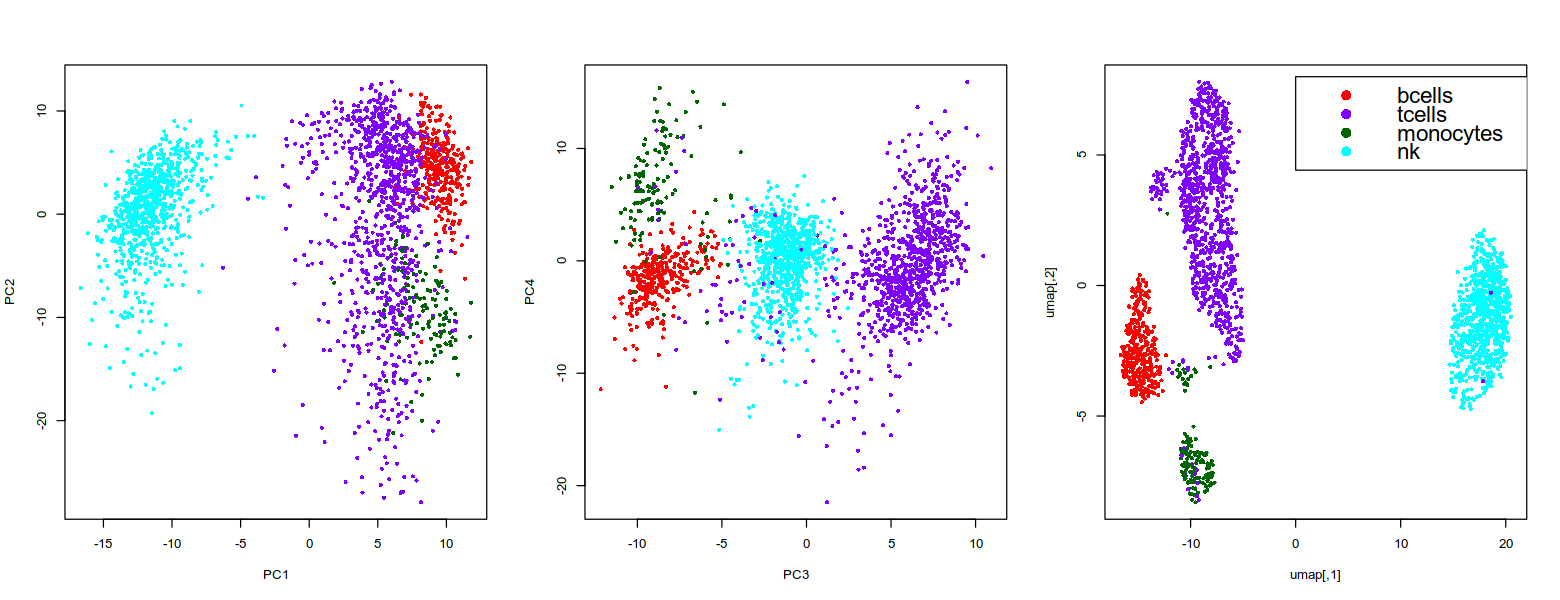

In [7]:
options(repr.plot.width=13, repr.plot.height=5)
par(mfrow = c(1,3))
plot(pca[,1:2], pch = 16, cex = 0.7, col = col.celltype)
plot(pca[,3:4], pch = 16, cex = 0.7, col = col.celltype)
plot(umap, pch = 16, cex = 0.7, col = col.celltype)
legend(x=0, y=8, legend = names(leg.col.celltype), pch = 16, cex = 1.7, col = leg.col.celltype)

## NORMALIZE FULL DATA

In [8]:
dim(counts) #genes as rows, cells as cols 

[1] 8863 2140

### scTransform

In [9]:
## sctranform normalization 
suppressMessages(norm.sct.obj <- sctransform::vst(counts, n_genes = NULL)) #genes as rows, cells as cols 
norm.sct <- norm.sct.obj$y
## set negative counts in norm.sct to 0 
norm.sct[norm.sct<0] <- 0

  |======================================================================| 100%
  |======================================================================| 100%


In [10]:
dim(norm.sct)
dim(counts)

## keep same genes as ones kept by sctransform
genes <- rownames(norm.sct)
counts <- counts[genes,]

[1] 8861 2140

[1] 8863 2140

### scaling factors

In [11]:
sf.libsize <- colSums(counts) / median(colSums(counts), na.rm = T)
sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(counts), type = 'poscounts')
sf.TMMwsp <- edgeR::calcNormFactors(counts, method = 'TMMwsp')  ## multiplied not divided

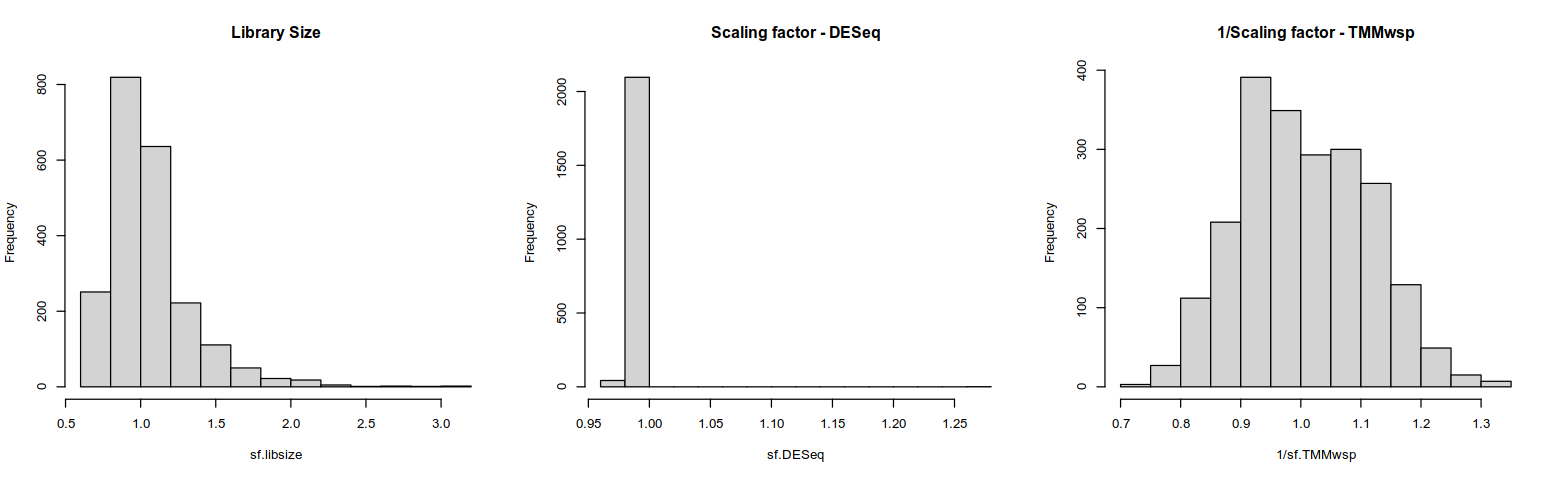

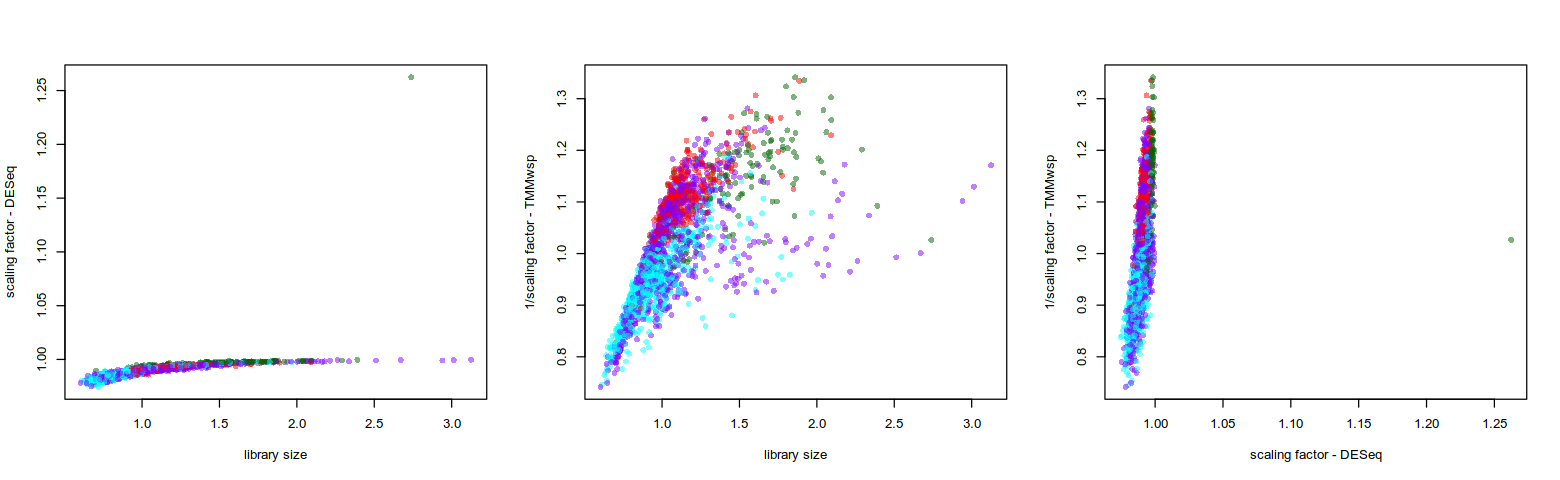

In [12]:
options(repr.plot.width=13, repr.plot.height=4)
par(mfrow = c(1,3))
hist(sf.libsize, main = 'Library Size')
hist(sf.DESeq, main = 'Scaling factor - DESeq')
hist(1/sf.TMMwsp, main = '1/Scaling factor - TMMwsp')

s <- 1

set.seed(0)
o <- sample(length(sf.libsize))

plot(sf.libsize[o], sf.DESeq[o], pch = 16, cex = s, col = scales::alpha(col.celltype[names(sf.libsize)[o]], 0.5), 
     xlab = 'library size', ylab = 'scaling factor - DESeq')
plot(sf.libsize[o], 1/sf.TMMwsp[o], pch = 16, cex = s, col = scales::alpha(col.celltype[names(sf.libsize)[o]], 0.5), 
     xlab = 'library size', ylab = '1/scaling factor - TMMwsp')
plot(sf.DESeq[o], 1/sf.TMMwsp[o], pch = 16, cex = s, col = scales::alpha(col.celltype[names(sf.libsize)[o]], 0.5), 
     xlab = 'scaling factor - DESeq', ylab = '1/scaling factor - TMMwsp')

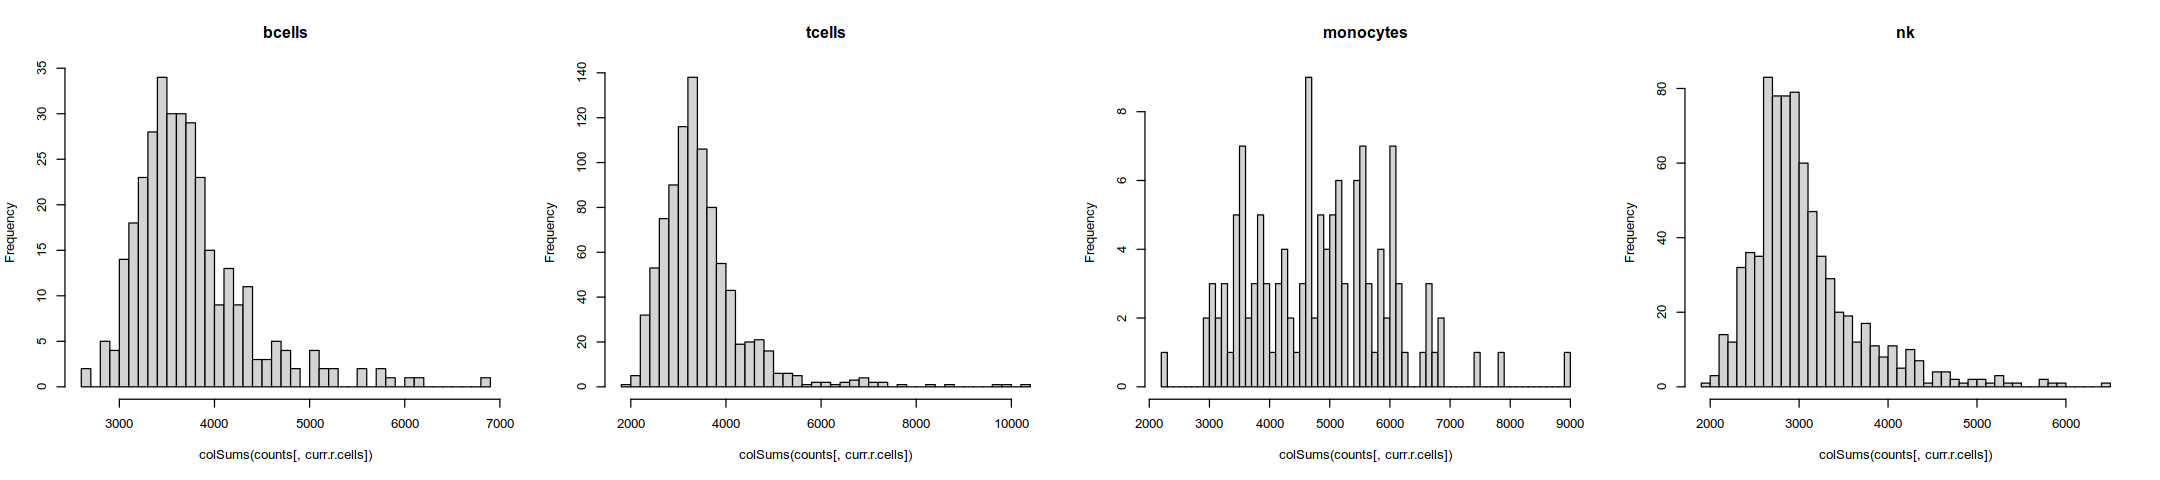

In [13]:
options(repr.plot.width=18, repr.plot.height=4)

par(mfrow = c(1,4))

celltypes.unq <- unique(celltype)
for (r in celltypes.unq){
    curr.r.cells <- names(celltype[celltype == r])
    hist(colSums(counts[,curr.r.cells]), breaks = 50, main = r)
}


### normalization

In [14]:
norm.none <- counts
norm.deseq <- t(t(counts)/sf.DESeq)
norm.tmm <- t(t(counts)*sf.TMMwsp)
norm.libsize <- t(t(counts)/sf.libsize)

all.norms <- list(nonorm = norm.none,
                 libsize = norm.libsize,
                 deseq = norm.deseq,
                 tmm = norm.tmm,
                 sct = norm.sct)


In [15]:
norms <- names(all.norms)
norms

[1] "nonorm"  "libsize" "deseq"   "tmm"     "sct"

## DE FULL DATA

In [16]:
cluster <- celltype
table(cluster)

cluster
   bcells monocytes        nk    tcells 
      330       129       769       912 

In [17]:
## get log fold changes and z-scores 
lfcs.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.lfcs <- find.log.fold.change(counts.norm, curr.cluster, log2)
    
    curr.lfcs
})

p.vals.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.pvals <- find.cluster.de.genes(counts.norm, cell.com = curr.cluster, test.alt = 'greater')
    curr.pvals
})

stats.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.stats <- find.cluster.test.stats(counts.norm, cell.com = curr.cluster, test.alt = 'greater')
    curr.stats
})

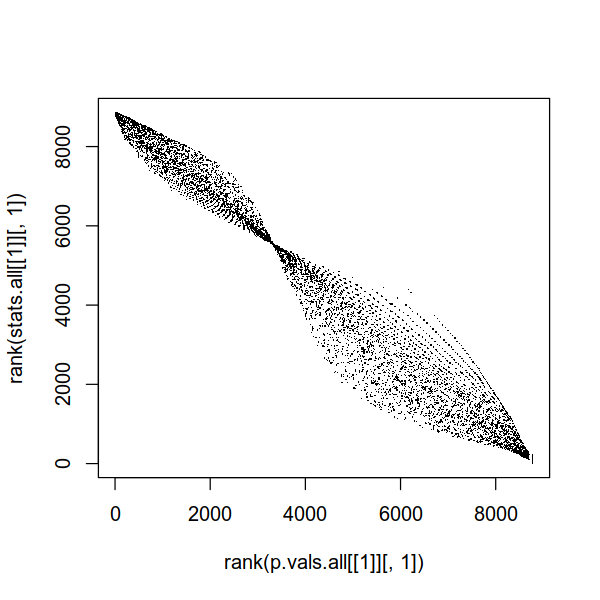

In [18]:
# head(stats.all[[1]])
# head(p.vals.all[[1]])
options(repr.plot.width=5, repr.plot.height=5)
plot(rank(p.vals.all[[1]][,1]), rank(stats.all[[1]][,1]), pch = '.')

In [19]:
# ## adjust pval for multiple comparisons
p.vals.all.adj <- lapply(p.vals.all, function(curr.pvals) {
    curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                             nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
    colnames(curr.pvals.adj) <- colnames(curr.pvals)
    rownames(curr.pvals.adj) <- rownames(curr.pvals)
    curr.pvals.adj
})

In [20]:
## pick DE genes based on ordered test statistic
de.genes <- lapply(norms, function(curr.norm) {
    curr.stat <- stats.all[[curr.norm]]
    curr.pvals <- p.vals.all.adj[[curr.norm]]
    curr.lfcs <- lfcs.all[[curr.norm]]
    
    curr.groups <- colnames(curr.stat)
    
    curr.de.genes <- lapply(curr.groups, function(curr.group) {
        curr.group.teststat <- curr.stat[,curr.group]
        curr.group.pvals <- curr.pvals[names(curr.group.teststat),curr.group]
        curr.group.lfcs <- curr.lfcs[names(curr.group.teststat),curr.group]
        
        curr.group.de.genes <- names(curr.group.teststat)[order(curr.group.teststat, decreasing = TRUE)]
        
        curr.group.de.genes.stats <- cbind(p.adj = curr.group.pvals[curr.group.de.genes], 
                                           logFC = curr.group.lfcs[curr.group.de.genes],
                                            teststat = curr.group.teststat[curr.group.de.genes])
        curr.group.de.genes.stats
    })
    names(curr.de.genes) <- curr.groups
    curr.de.genes
})
names(de.genes) <- norms

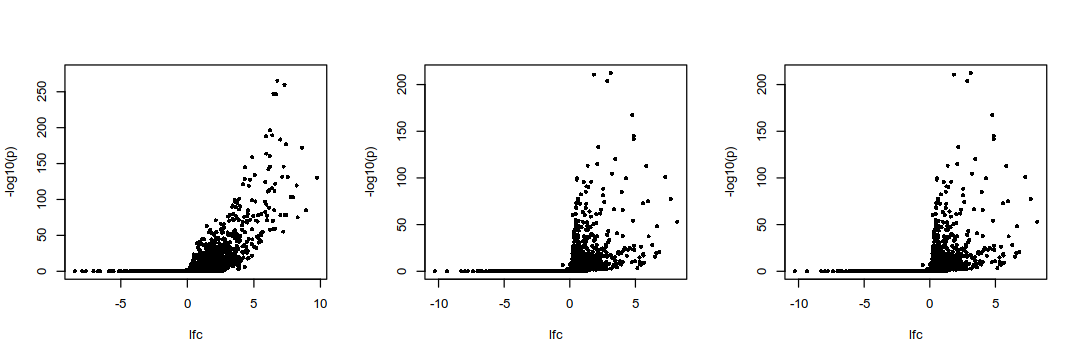

In [21]:
options(repr.plot.width=9, repr.plot.height=3)
par(mfrow = c(1,3))
plot(lfcs.all$nonorm[,'monocytes'], -1*log10(p.vals.all.adj$nonorm[,'monocytes']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')

foo <- rownames(de.genes$nonorm$bcells)
plot(lfcs.all$nonorm[foo,'tcells'], -1*log10(p.vals.all.adj$nonorm[foo,'tcells']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')

plot(de.genes$nonorm$tcells[,'logFC'],-1*log10(de.genes$nonorm$tcells[,'p.adj']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')



[1] 20

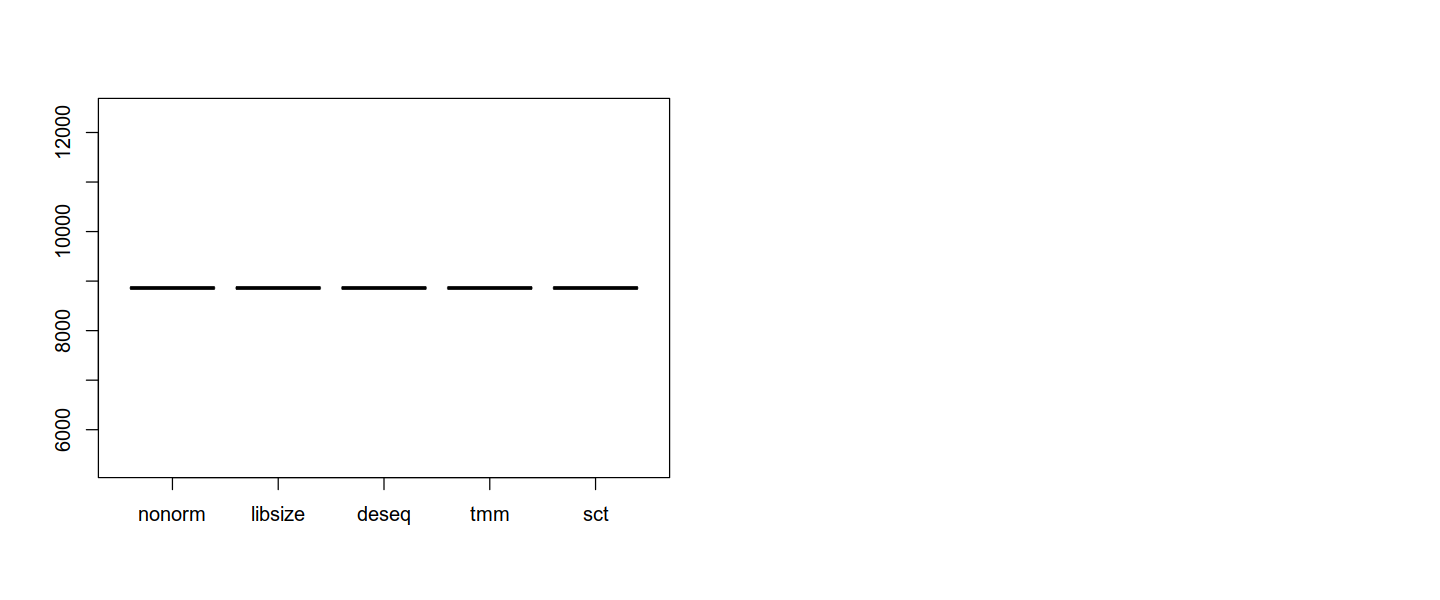

In [22]:
## n DE genes for each cell type per normalization methods
options(repr.plot.width=12, repr.plot.height=5)

n.DEs <- sapply(de.genes, function(x) {
    n.de <- sapply(x, nrow)
    n.de
})

length(n.DEs)
# n.DEs
par(mfrow = c(1,2))
boxplot(n.DEs)

## GENE SUBSETS


In [23]:
regions <- unique(cluster)
regions
genes <- rownames(counts)
length(genes)
head(genes)

[1] "bcells"    "tcells"    "monocytes" "nk"

[1] 8861

[1] "LINC00115" "NOC2L"     "ISG15"     "C1orf159"  "TNFRSF18"  "TNFRSF4"

In [24]:
## top N DE genes 
set.seed(0)
genesets.all <- lapply(regions, function(r) {
    
    curr.r.de.genes <- lapply(de.genes, function(x) {data.frame(x[[r]], name = rownames(x[[r]]))} )
    curr.r.de.genes <- Reduce(function(x,y) {merge(x,y, all=TRUE)}, curr.r.de.genes)
    curr.r.de.genes <- curr.r.de.genes[order(curr.r.de.genes$p.adj),]
    curr.r.de.genes <- curr.r.de.genes[!duplicated(curr.r.de.genes$name),]
    
    curr.r.de.genes$name
    
})
names(genesets.all) <- regions

sapply(genesets.all, length)

geneset.sizes <- c(50, 100, 500, 1000, 5000, length(genes))


genesets <- lapply(geneset.sizes, function(curr.gs.size) {
    curr.genesets <- lapply(genesets.all, function(x) { x[1:curr.gs.size] })
    curr.random <- sample(genes, curr.gs.size)
    curr.genesets[['random']] <- curr.random
    curr.genesets
})
names(genesets) <- geneset.sizes

bcells    tcells monocytes        nk 
     8861      8861      8861      8861

## COUNT SUBSETS

In [25]:
counts.subsets <- lapply(genesets, function(curr.gs) {
    curr.counts.subsets <- lapply(curr.gs, function(gs) {
        curr.gs.counts <- counts[gs,]
        curr.empty.cells <- colSums(curr.gs.counts)==0
        curr.gs.counts <- curr.gs.counts[,!curr.empty.cells]
        curr.gs.counts
    })
})
names(counts.subsets) <- geneset.sizes
sapply(counts.subsets, function(x) {sapply(x, dim)})

50,100,500,1000,5000,8861
50,100,500,1000,5000,8861
2140,2140,2140,2140,2140,2140
50,100,500,1000,5000,8861
2140,2140,2140,2140,2140,2140
50,100,500,1000,5000,8861
1955,2140,2140,2140,2140,2140
50,100,500,1000,5000,8861
2140,2140,2140,2140,2140,2140
50,100,500,1000,5000,8861
2140,2140,2140,2140,2140,2140


In [32]:
dim(counts.subsets[[1]][[1]])

[1]   50 2140

In [31]:
saveRDS(counts.subsets, file = 'scpbmc_sizeSim_countssubsets.RDS')

#### make folders

In [34]:
save.dir
for (i in names(genesets[[1]])){
    dir.create(paste0(save.dir,i))
}

[1] "./figs/figs_feb_26_2/"

In [35]:
save.dir
for (i in names(genesets[[1]])){
    dir.create(paste0(save.dir,i,'/heatmaps/'))
}

[1] "./figs/figs_feb_26_2/"

### heatmap

In [36]:
gs.names <- c('B cells', 'T cells', 'Monocytes', 'NK cells', NA)
names(gs.names) <- names(genesets[[1]])
gs.order <- c(1,2,3,4)
gs.names[gs.order]

bcells      tcells   monocytes          nk 
  "B cells"   "T cells" "Monocytes"  "NK cells"

In [33]:
for (curr.size in geneset.sizes){
    curr.size.genesets <- genesets[[as.character(curr.size)]]
    
    # get skewed geneset genes (minus random geneset)
    hm.genes <- unlist(curr.size.genesets[1:4])

    # find which genes are duplicated 
    hm.genes.dups <- unique(hm.genes[duplicated(hm.genes)])
    length(hm.genes.dups)

    # remove duplicated genes (all instances)
    hm.genes <- hm.genes[! hm.genes %in% hm.genes.dups]
    length(hm.genes)

    # add one instance of duplicate genes back lol - but now they're at the front
    hm.genes <- c(hm.genes.dups, hm.genes)
    length(hm.genes)

    # add non DE genes to the front 
    hm.genes.nongs <- rownames(counts)[! rownames(counts) %in% hm.genes]
    hm.genes <- c(hm.genes, hm.genes.nongs)
    length(hm.genes)

    ### order should be: [non DE genes][DE genes for more than one region][specific DE genes]
    htmp.col <- rev(colorRampPalette(brewer.pal(11, "RdBu"))(100))
    
    # average within tissue region
    gexp.reg.avg <- matrix(0, ncol = length(names(curr.size.genesets))-1, nrow = nrow(counts))
    colnames(gexp.reg.avg) <- names(curr.size.genesets)[1:4]
    rownames(gexp.reg.avg) <- rownames(counts)
    
    for (gs in colnames(gexp.reg.avg)){
#         print(gs)
        curr.cells <- names(cluster[cluster == gs])
#         print(length(curr.cells))
        curr.gs.avg.gexp <- rowMeans(counts[,curr.cells])
        gexp.reg.avg[,gs] <- curr.gs.avg.gexp
    }
    
    # mean exp skewed gene panel heat map
    s <- 'row'

    for (gs in names(curr.size.genesets)){
        foo.genes <- curr.size.genesets[[gs]]
        hm.genes.gs <- hm.genes[hm.genes %in% foo.genes]

        pdf(paste0(save.dir, gs, '/heatmaps/heatmap_',curr.size,'.pdf'), width = 7, height = 5)
        par(mfrow = c(1,1), mar = c(5.1, 4.1, 4.1, 2.1))

        heatmap(gexp.reg.avg[hm.genes.gs,gs.order], scale = 'row', col = htmp.col, 
                Colv = NA, Rowv = NA, 
                ColSideColors = leg.col.celltype[colnames(gexp.reg.avg[,gs.order])],
               labRow = FALSE, labCol = FALSE,
    #               trace = 'none',
                margins = c(3.8,2.1)
               )
        if (gs == 'random'){
            title(ylab=paste('Genes\nNon-skewed gene panel'), line=0.5, cex.lab=2)
        } else {
            title(ylab=paste0('Genes\n', gs.names[gs], '-skewed gene panel'), line=0.5, cex.lab=2)
        }
        title(xlab=paste('Cells'), line=4, cex.lab=2)
        dev.off()
    }    
}

### scaling factors skewed genesets

In [37]:
skewed.sfs <- lapply(counts.subsets, function(curr.size.counts) {
    curr.size.sfs <- lapply(curr.size.counts, function(curr.gs.counts) {
        curr.libsize <- colSums(curr.gs.counts)/ median(colSums(curr.gs.counts), na.rm = T)
        curr.sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(curr.gs.counts), type = 'poscounts')
        curr.sf.TMMwsp <- edgeR::calcNormFactors(curr.gs.counts, method = 'TMMwsp')  ## multiplied not divided
        
        list(libsize = curr.libsize,
             deseq = curr.sf.DESeq,
             tmm = curr.sf.TMMwsp)
    })
})

In [38]:
names(skewed.sfs)
names(skewed.sfs[[1]])
names(skewed.sfs[[1]][[1]])

[1] "50"   "100"  "500"  "1000" "5000" "8861"

[1] "bcells"    "tcells"    "monocytes" "nk"        "random"

[1] "libsize" "deseq"   "tmm"

In [39]:
sf.all <- list(libsize = sf.libsize,
               deseq = sf.DESeq,
               tmm = sf.TMMwsp)

## COMPARE SCALING FACTORS: SKEWED vs FULL

In [40]:
save.dir
for (i in names(genesets[[1]])){
    dir.create(paste0(save.dir,i,'/scaling_factor_comparison/'))
}

[1] "./figs/figs_feb_26_2/"

In [41]:
names(genesets[[1]])

[1] "bcells"    "tcells"    "monocytes" "nk"        "random"

In [42]:
options(repr.plot.width=20, repr.plot.height=15)

norms.to.include <- c('libsize')
norms.to.include <- c('libsize', 'deseq', 'tmm')
norms.names <- c('Library Size', 'DESeq2', 'TMM')
names(norms.names) <- norms.to.include
fs <- 4

for (n in norms.to.include){
    
    for (g in names(genesets[[1]])){
    #     png(paste0(save.dir,'/scaling_factor_comparison_', g,'_skewed_vs_all_genes_grouped.png'), width = 450, height = 2500)
        pdf(paste0(save.dir,g,'/scaling_factor_comparison/',n,'.pdf'), 
            width = 6, height = 30)

        par(mfrow = c(6,1), mar = c(10.1, 10.1, 6.1, 2.1)) #mar = c(5.1, 4.1, 4.1, 2.1)    
        for (s in names(genesets)){  

            curr.sfs.skewed <- skewed.sfs[[s]][[g]][norms.to.include]
            curr.common.cells <- Reduce(intersect, lapply(curr.sfs.skewed, names))

            curr.sf.skewed <- curr.sfs.skewed[[n]]
            curr.sf.all <- sf.all[[n]]

            curr.x <- log10(curr.sf.all[curr.common.cells]+1)
            curr.x.lim <- range(curr.x, finite = TRUE)

            curr.y <- log10(curr.sf.skewed[curr.common.cells]+1)
            curr.y.lim <- range(curr.y, finite = TRUE)
            
            #change color to highlight roi for region skewed geneset
            curr.cols <- col.celltype
            curr.cols[celltype != g] <- 'grey'

            #use all colors for random geneset
            if (g == 'random'){
                curr.cols <- col.celltype
            }

            #reorder when all together
            o <- sample(length(curr.x))
            o <- sample(o)            

            plot(curr.x[o], curr.y[o],
                 pch = 16, cex = 2, col = scales::alpha(curr.cols[curr.common.cells][o], 0.25), # ylim = c(0,3),
                 cex.lab = fs, cex.axis = fs, cex.main = fs, xaxt="n", yaxt="n",
                 bty = 'n', xaxs = 'i', yaxs = 'i',
                 xlim = curr.x.lim, ylim = curr.y.lim, xlab = '', ylab = '',
    #                  xlab = paste('Full gene panel\n log_10(scaling factor)'), 
    #                  ylab = paste('Skewed gene panel\n log_10(scaling factor)'), 
                 main = paste0(s, '-gene gene panel'))
            title(xlab=paste('Full gene panel'), line=8, cex.lab=fs)
            title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
            axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 1, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 2, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 1, line = 1.5, cex.axis = fs, lty = 0)
            axis(side = 2, line = 0.5, cex.axis = fs, lty = 0)
            abline(a=0,b=1,col='red')


        }
        dev.off()
    }
    
    
}



## NORMALIZE SKEWED GENESETS

In [43]:
skewed.norms <- lapply(names(counts.subsets), function(curr.size) {
    curr.size.counts <- counts.subsets[[curr.size]]
    print(names(curr.size.counts))
    curr.size.skewed.norms <- lapply(names(curr.size.counts), function(curr.gs) {
        curr.counts <- curr.size.counts[[curr.gs]]
        curr.sfs <- skewed.sfs[[curr.size]][[curr.gs]]
        
        curr.norm.none <- curr.counts
        curr.norm.libsize <- t(t(curr.counts)/curr.sfs[['libsize']]) #*median(A.sf.libsize, na.rm = T) #colSums(countsA)
        curr.norm.deseq <- t(t(curr.counts)/curr.sfs[['deseq']])
        curr.norm.tmm <- t(t(curr.counts)*curr.sfs[['tmm']])
        
        suppressMessages(curr.sct <- sctransform::vst(curr.counts, n_genes = NULL))
        curr.norm.sct <- curr.sct$y
        curr.norm.sct[curr.norm.sct<0] <- 0
        
        curr.norms <- list(nonorm = curr.norm.none,
                           libsize = curr.norm.libsize,
                           deseq = curr.norm.deseq,
                           tmm = curr.norm.tmm,
                           sct = curr.norm.sct)
        curr.norms
        
    })
    names(curr.size.skewed.norms) <- names(curr.size.counts)
    curr.size.skewed.norms
})
names(skewed.norms) <- names(counts.subsets)

[1] "bcells"    "tcells"    "monocytes" "nk"        "random"   
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
[1] "bcells"    "tcells"    "monocytes" "nk"        "random"   
  |=====================================================================

## COUNT CORRELATIONS

In [41]:
# gene.count.corrs <- lapply(skewed.norms, function(curr.size.skewed.norms) {
#     curr.size.gene.corrs <- lapply(curr.size.skewed.norms, function(curr.gs.skewed.norms) {
#         curr.gs.gene.corrs <- lapply(norms, function(n) {
#             curr.skewed.norm.counts <- curr.gs.skewed.norms[[n]]
#             curr.all.norm.counts <- all.norms[[n]]
            
#             curr.cells <- intersect(colnames(curr.skewed.norm.counts), colnames(curr.all.norm.counts))
#             curr.genes <- intersect(rownames(curr.skewed.norm.counts), rownames(curr.all.norm.counts))
            
#             curr.skewed.norm.counts <- curr.skewed.norm.counts[curr.genes, curr.cells]
#             curr.all.norm.counts <- curr.all.norm.counts[curr.genes, curr.cells]
            
#             curr.corrs <- sapply(curr.genes, function(g) {
#                 cor(curr.skewed.norm.counts[g,], curr.all.norm.counts[g,], method = 'pearson')
#             })
#             curr.corrs
#         })
#         names(curr.gs.gene.corrs) <- norms
#         as.data.frame(curr.gs.gene.corrs)
#     })
# })

In [42]:
# options(repr.plot.width=18, repr.plot.height=5)

# norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'nonorm')
# norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'No Normalization')
# names(norms.names) <- norms.to.include
# xtcks <- c(0:length(norms.to.include)+1)

# yl <- lapply(gene.count.corrs, function(x) {
#     c(min(sapply(x, function(y) {
#         min(y, na.rm = T)})), 1)
# })
# yl <- range(unlist(yl))
# yl <- c(-0.4,1)

# for (g in names(genesets[[1]])){
#     pdf(paste0(save.dir,g, '/gene_count_correlation.pdf'), width = 6, height = 30)
#     par(mfrow = c(6,1), mar = c(17.1, 10, 3.1, 2.1))
#     for (gs in names(genesets)){
#         curr.corrs <- gene.count.corrs[[gs]][[g]]
# #         curr.yl <- yl[[gs]]
#         curr.yl <- yl
        
#         if (gs != '8861'){
#             boxplot(curr.corrs[,norms.to.include], ylim = curr.yl, #ylim = ylr, #ylim = yl,
#                     cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxs = 'i', yaxs = 'i',
#                     xaxt = "n", yaxt = "n", frame.plot=FALSE,
#                     ylab = '')
#             axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE) #x axis ticks
#             axis(2, at = c(-0.4,-0.2,0,0.2,0.4,0.6,0.8,1), cex.axis=3, las = 2)
#             title(ylab='Pearson Correlation', line=6, cex.lab=fs)            
#         }


        
#         if (gs == '8861'){
#             par(mar = c(17.1, 10, 3.1, 2.1))
#             boxplot(curr.corrs[,norms.to.include], ylim = curr.yl, #ylim = ylr, #ylim = yl,
#                     cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxs = 'i', yaxs = 'i',
#                     xaxt = "n", yaxt = "n", frame.plot=FALSE,
#                     ylab = '')
#             axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE) #x axis ticks
#             axis(2, at = c(-0.4,-0.2,0,0.2,0.4,0.6,0.8,1), cex.axis=3, las = 2)
#             title(ylab='Pearson Correlation', line=6, cex.lab=fs)
#             text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(curr.yl)-0.02, labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2) ##ventricles/random
#             title(xlab='Normalization', line=14, cex.lab=fs)            
#         }
        
#     }
#     dev.off()

# }




## DE GENES SKEWED GENESETS

In [44]:
skewed.lfcs <- lapply(skewed.norms, function(curr.size.skewed.norms) {
    curr.size.lfcs <- lapply(curr.size.skewed.norms, function(curr.gs.norms) {
        curr.gs.lfcs <- lapply(curr.gs.norms, function(curr.counts.norm) {
            curr.clusters <- cluster[colnames(curr.counts.norm)]
            names(curr.clusters) <- colnames(curr.counts.norm)
            curr.lfcs <- find.log.fold.change(curr.counts.norm, curr.clusters, log2)

            curr.lfcs                
        })
        
        curr.gs.lfcs
    })
    curr.size.lfcs
})

skewed.pvals <- lapply(skewed.norms, function(curr.size.skewed.norms) {
    curr.size.pvals <- lapply(curr.size.skewed.norms, function(curr.gs.norms) {
        curr.gs.pvals <- lapply(curr.gs.norms, function(curr.counts.norm) {
            curr.clusters <- cluster[colnames(curr.counts.norm)]
            names(curr.clusters) <- colnames(curr.counts.norm)
            curr.pvals <- find.cluster.de.genes(curr.counts.norm, cell.com = curr.clusters, test.alt = 'greater')

            curr.pvals            
        })
        curr.gs.pvals
        
    })
    curr.size.pvals
})

skewed.pvals.adj <- lapply(skewed.pvals, function(curr.size.pvals) {
    curr.size.pvals.adj <- lapply(curr.size.pvals, function(curr.gs.pvals) {
        curr.gs.pvals.adj <- lapply(curr.gs.pvals, function(curr.pvals) {
            curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                                     nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
            colnames(curr.pvals.adj) <- colnames(curr.pvals)
            rownames(curr.pvals.adj) <- rownames(curr.pvals)

            curr.pvals.adj            
        })
        curr.gs.pvals.adj
        
    })
    curr.size.pvals.adj
})

## GENE PANEL DIVERSITY

In [48]:
# names(genesets)
# names(genesets[[1]])
# norms

[1] "50"   "100"  "500"  "1000" "5000" "8861"

[1] "bcells"    "tcells"    "monocytes" "nk"        "random"

[1] "nonorm"  "libsize" "deseq"   "tmm"     "sct"

In [49]:
# ## de genes for skewed genesets 
# p.thresh <- 0.05
# lfc.thresh <- 0.25

# skewed.de.genes <- lapply(names(genesets), function(curr.size) {
#     curr.size.de.genes <- lapply(names(genesets[[1]]), function(curr.gs) {
#         curr.gs.de.genes <- lapply(norms, function(curr.norm) {
#             curr.pvals <- skewed.pvals.adj[[curr.size]][[curr.gs]][[curr.norm]]
#             curr.lfcs <- skewed.lfcs[[curr.size]][[curr.gs]][[curr.norm]]
            
#             curr.groups <- colnames(curr.pvals)
#             curr.de.genes <- lapply(curr.groups, function(curr.group) {
#                 curr.group.pvals <- curr.pvals[,curr.group]
#                 curr.group.lfcs <- curr.lfcs[names(curr.group.pvals), curr.group]
                
#                 curr.group.de.genes <- names(curr.group.pvals)[curr.group.pvals<p.thresh & abs(curr.group.lfcs)>lfc.thresh]
#                 curr.group.de.genes.stats <- cbind(curr.group.pvals[curr.group.de.genes],
#                                                    curr.group.lfcs[curr.group.de.genes])
#                 colnames(curr.group.de.genes.stats) <- c('p.adj','logFC')
#                 curr.group.de.genes.stats
#             })
#             names(curr.de.genes) <- curr.groups
#             curr.de.genes
#         })
#         names(curr.gs.de.genes) <- norms
#         curr.gs.de.genes
#     })
#     names(curr.size.de.genes) <- names(genesets[[1]])
#     curr.size.de.genes
# })
# names(skewed.de.genes) <- names(genesets)

In [51]:
# ## number of de genes
# skewed.n.DEs <- lapply(skewed.de.genes, function(curr.size.de.genes) {
#     curr.gs.n.DEs <- lapply(curr.size.de.genes, function(curr.de.genes) {
#         curr.n.DEs <- sapply(curr.de.genes, function(x) {
#             sapply(x, nrow)
#         })
#         curr.n.DEs
#     })
#     curr.gs.n.DEs
# })


In [80]:
# skewed.props <- lapply(names(skewed.n.DEs), function(curr.size.n) {
#     curr.size <- skewed.n.DEs[[curr.size.n]]
#     curr.size.n <- as.numeric(curr.size.n)
    
#     lapply(curr.size, function(curr.gs) {
#         curr.gs[,'nonorm']/curr.size.n
#     })
# })
# names(skewed.props) <- names(skewed.n.DEs)

In [87]:
# skewed.div <- lapply(skewed.props, function(curr.size) {
#     sapply(curr.size, function(x) {
#         x <- x[x>0]
#         -1*sum(x*log(x))
#     })
# })

## COMPARE P VALUES: SKEWED vs OG

In [45]:
save.dir
for (i in names(genesets[[1]])){
    dir.create(paste0(save.dir,i,'/pval_comparison/'))
}

[1] "./figs/figs_feb_26_2/"

In [46]:
options(repr.plot.width=5, repr.plot.height=18)
fs <- 4

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'No Normalization')
names(norms.names) <- norms.to.include
set.seed(0)

for (n in norms.to.include){

    for (gs in names(genesets[[1]])){
    #     png(paste0(save.dir,'/pval_comparison_', gs, '_skewed_vs_all_genes_log.png'), width = 450, height = 2500)
        pdf(paste0(save.dir,gs,'/pval_comparison/',n,'.pdf'), 
            width = 6, height = 30)
        par(mfrow = c(6,1), mar = c(10.1, 10.1, 6.1, 2.1))

        for (s in names(genesets)){
            
            curr.skewed.pvalsAdj <- -1*log10(skewed.pvals.adj[[s]][[gs]][[n]])
#             curr.skewed.pvalsAdj <- (skewed.pvals.adj[[s]][[gs]][[n]])

            curr.geneset <- rownames(curr.skewed.pvalsAdj)

            curr.og.pvalsAdj <- -1*log10(p.vals.all.adj[[n]][curr.geneset,])
#             curr.og.pvalsAdj <- (p.vals.all.adj[[n]][curr.geneset,])


            #change color to highlight roi for region skewed geneset
            curr.cols <- colnames(curr.skewed.pvalsAdj)
            curr.cols <- leg.col.celltype[curr.cols]
            curr.cols[names(curr.cols) != gs] <- 'grey'
    #         print(curr.cols)

            #use all colors for random geneset
            if (gs == 'random'){
                curr.cols <- colnames(curr.skewed.pvalsAdj)
                curr.cols <- leg.col.celltype[curr.cols]
            }

            curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.pvalsAdj))}))

            plot(as.vector(curr.og.pvalsAdj), as.vector(curr.skewed.pvalsAdj), 
                 pch = 16, cex = 2, col = scales::alpha(curr.cols, 0.75),
#                  xlim = c(0,10), ylim = c(0,10),
                 cex.lab = fs, cex.axis = fs, cex.main = fs, xaxt="n", yaxt="n",
                 xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
#                  xlab = paste(n, '-log10(p) - all genes'), 
#                  ylab = paste(n, '-log10(p) - skewed genes'), 
                 main = paste0(s, '-gene gene panel'))
            title(xlab=paste('Full gene panel'), line=8, cex.lab=fs)
            title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
            axis(side = 1, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 2, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 1, line = 1.5, cex.axis = fs, lty = 0)
            axis(side = 2, line = 0.5, cex.axis = fs, lty = 0)            
            abline(a=0,b=1,col='red')
#             abline(v=-1*log10(0.05), h=-1*log10(0.05), col = 'red')
#             abline(v=0.05, h=0.05, col = 'red')



        }

        dev.off()

    }    
    
}




## PVAL FP FN

In [47]:
dir.create(paste0(save.dir,'FP_FN'))

In [ ]:
fpfn.pvals <- lapply(names(skewed.pvals.adj), function(curr.size) {
    curr.size.pvals.adj <- skewed.pvals.adj[[curr.size]]
    curr.size.fpfn.pvals <- lapply(names(curr.size.pvals.adj), function(reg) {
        gs <- curr.size.pvals.adj[[reg]]
        curr.gs.fpfn <- lapply(names(gs), function(n) {
            curr.skewed.pvals <- gs[[n]]
            curr.full.pvals <- p.vals.all.adj[[n]]
            
            curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
            curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
            curr.full.pvals <- curr.full.pvals[curr.genes,]
            
            get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        })
        names(curr.gs.fpfn) <- names(gs)
        curr.gs.fpfn
    })
    names(curr.size.fpfn.pvals) <- names(curr.size.pvals.adj)
    curr.size.fpfn.pvals
})
names(fpfn.pvals) <- names(skewed.pvals.adj)

fpfn.rate.pvals <- lapply(fpfn.pvals, function(curr.size.fpfn.pvals) {
    curr.size.fpfn.rate.pvals <- lapply(curr.size.fpfn.pvals, function(gs) {
        curr.gs.fpfn.rate.pvals <- sapply(gs, function(n) {
            
            curr.fp <- n[['false.positive']]
            curr.fp.rate <- sum(curr.fp)/n.panel
            
            curr.fn <- n[['false.positive']]
            curr.fn.rate <- sum(curr.fn)/n.panel
            
            list(fp = curr.fp.rate, fn = curr.fn.rate)
        })
        curr.gs.fpfn.rate.pvals
    })
    curr.size.fpfn.rate.pvals
})

# error.rate.pvals <- lapply(fpfn.rate.pvals, function(curr.size.fpfn.rate) {
#     curr.size.error.rate <- lapply(curr.size.fpfn.rate, function(curr.celltype.fpfn.rate) {
#         curr.celltype.fpfn.rate <- matrix(unlist(curr.celltype.fpfn.rate), nrow = 2)
#         colnames(curr.celltype.fpfn.rate) <- norms
#         colMeans(curr.celltype.fpfn.rate)
#     })
# })

# err.pvals.by.celltype <- lapply(celltypes, function(ct) {
#     sapply(error.rate.pvals, function(curr.size) {
#         curr.size[[ct]]
#     })
# })
# names(err.pvals.by.celltype) <- celltypes

In [48]:
fpfn.pvals <- lapply(names(skewed.pvals.adj), function(curr.size) {
    curr.size.pvals.adj <- skewed.pvals.adj[[curr.size]]
    curr.size.fpfn.pvals <- lapply(names(curr.size.pvals.adj), function(reg) {
        gs <- curr.size.pvals.adj[[reg]]
        curr.gs.fpfn <- lapply(names(gs), function(n) {
            curr.skewed.pvals <- gs[[n]]
            curr.full.pvals <- p.vals.all.adj[[n]]
            
            curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
            curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
            curr.full.pvals <- curr.full.pvals[curr.genes,]
            
            get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        })
        names(curr.gs.fpfn) <- names(gs)
        curr.gs.fpfn
    })
    names(curr.size.fpfn.pvals) <- names(curr.size.pvals.adj)
    curr.size.fpfn.pvals
})
names(fpfn.pvals) <- names(skewed.pvals.adj)

In [114]:
names(fpfn.pvals)
names(fpfn.pvals[[1]])
names(fpfn.pvals[[1]][[1]])
names(fpfn.pvals[[1]][[1]][[1]])
sum(fpfn.pvals[[1]][[1]][[1]][[2]])

[1] "50"   "100"  "500"  "1000" "5000" "8861"

[1] "bcells"    "tcells"    "monocytes" "nk"        "random"

[1] "nonorm"  "libsize" "deseq"   "tmm"     "sct"

[1] "false.positive" "false.negative"

[1] 0

In [ ]:
fpfn.pvals <- lapply(names(skewed.pvals.adj), function(reg) {
    gs <- skewed.pvals.adj[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.pvals <- gs[[n]]
        curr.full.pvals <- p.vals.all.adj[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
        
        curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
        curr.full.pvals <- curr.full.pvals[curr.genes,]
        
        get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
})
names(fpfn.pvals) <- names(skewed.pvals.adj)

fpfn.rate.pvals.all <- lapply(names(fpfn.pvals), function(reg) {
    gs <- fpfn.pvals[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.fp.rate <- sum(curr.fp)/length(curr.fp)
        
        curr.fn <- n[['false.negative']]
        curr.fn.rate <- sum(curr.fn)/length(curr.fn)
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.pvals.all) <- names(fpfn.pvals)

fpfn.rate.pvals.reg.other <- lapply(names(fpfn.pvals), function(reg) {
    gs <- fpfn.pvals[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        
        if (reg != 'random'){
            curr.reg.fp <- n[['false.positive']][,reg]
            curr.reg.fp.rate <- sum(curr.reg.fp)/length(curr.reg.fp)
            
            curr.reg.fn <- n[['false.negative']][,reg]
            curr.reg.fn.rate <- sum(curr.reg.fn)/length(curr.reg.fn)
            
            curr.other.regs <- colnames(n[['false.positive']]) != reg
            
            curr.other.fp <- n[['false.positive']][,curr.other.regs]
            curr.other.fp.rate <- sum(curr.other.fp)/length(curr.other.fp)
            
            curr.other.fn <- n[['false.negative']][,curr.other.regs]
            curr.other.fn.rate <- sum(curr.other.fn)/length(curr.other.fn)
            
        } else {
            curr.reg.fp.rate <- NA
            curr.reg.fn.rate <- NA
            curr.other.fp.rate <- NA
            curr.other.fn.rate <- NA            
        }
        
        list(fp.reg = curr.reg.fp.rate, fn.reg = curr.reg.fn.rate,
            fp.other = curr.other.fp.rate, fn.other = curr.other.fn.rate)
        
    })
    
    curr.gs.fpfn.rates
    
})
names(fpfn.rate.pvals.reg.other) <- names(fpfn.pvals)

fp.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fp',])
}))
fn.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fn',])
}))

fp.pvals.reg <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fp.reg',])
}))
fn.pvals.reg <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fn.reg',])
}))

fp.pvals.other <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fp.other',])
}))
fn.pvals.other <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fn.other',])
}))


## COMPARE LOG FCS: SKEWED vs OG

In [91]:
save.dir
for (i in names(genesets[[1]])){
    dir.create(paste0(save.dir,i,'/logFC_comparison/'))
}

[1] "./figs/figs_jan_31_entropy/"

In [92]:
options(repr.plot.width=5, repr.plot.height=18)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'No Normalization')
names(norms.names) <- norms.to.include
set.seed(0)

for (n in norms.to.include){
    for (gs in names(genesets[[1]])){
        pdf(paste0(save.dir,gs,'/logFC_comparison/',n,'.pdf'),  
            width = 6, height = 30)
        par(mfrow = c(6,1), mar = c(10.1, 10.1, 6.1, 2.1))

        for (s in names(genesets)){

            curr.skewed.lfcs <- skewed.lfcs[[s]][[gs]][[n]]
            curr.geneset <- rownames(curr.skewed.lfcs)
            curr.og.lfcs <- lfcs.all[[n]][curr.geneset,]

            #change color to highlight roi for region skewed geneset
            curr.cols <- colnames(curr.skewed.lfcs)
            curr.cols <- leg.col.celltype[curr.cols]
            curr.cols[names(curr.cols) != gs] <- 'grey'
    #         print(curr.cols)

            #use all colors for random geneset
            if (gs == 'random'){
                curr.cols <- colnames(curr.skewed.lfcs)
                curr.cols <- leg.col.celltype[curr.cols]
            }

            curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.lfcs))}))

            curr.x.lim <- range(curr.og.lfcs, finite = TRUE)
            curr.y.lim <- range(curr.skewed.lfcs, finite = TRUE)

            plot(as.vector(curr.og.lfcs), as.vector(curr.skewed.lfcs), 
                 pch = 16, cex = 2, col = scales::alpha(curr.cols, 0.75),
                 cex.lab = fs, cex.axis = fs, cex.main = fs, xaxt="n", yaxt="n",
                 xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
    #                  xlab = paste(n, 'log10(FC) - all genes'), 
    #                  ylab = paste(n, 'log10(FC) - skewed genes'), 
                 main = paste0(s, '-gene gene panel'))
            title(xlab=paste('Full gene panel'), line=8, cex.lab=fs)
            title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
            axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 1, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 2, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
            axis(side = 1, line = 1.5, cex.axis = fs, lty = 0)
            axis(side = 2, line = 0.5, cex.axis = fs, lty = 0)
            abline(a=0,b=1,col='red')
            abline(v=0, col='black')
            abline(h=0, col='black')
            abline(v=c(-0.25,0.25), col=scales::alpha('grey',0.5))
            abline(h=c(-0.25,0.25), col=scales::alpha('grey',0.5))  

        }

        dev.off()

    }    
}


